In [7]:
import numpy as np
import matplotlib.pyplot as plt
import os

In [8]:
dir = 'models'
os.listdir(dir)

['wflc_small_snr0_1000_losses.npy']

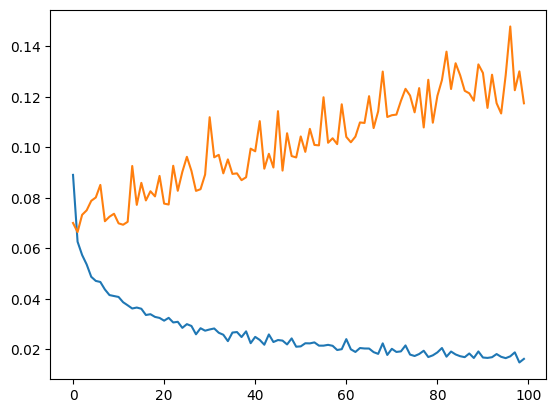

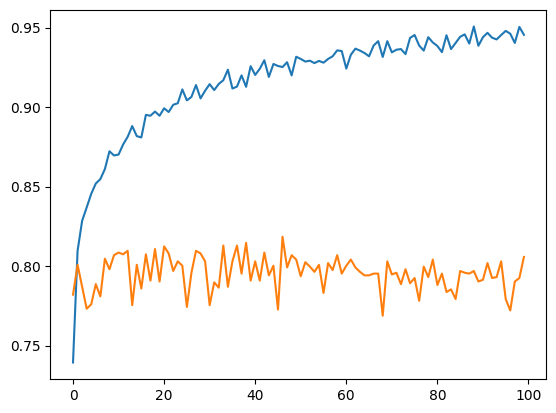

In [22]:
for filename in os.listdir(dir):
    train_loss, train_acc, val_loss, val_acc = np.load(os.path.join(dir, filename), allow_pickle=True)
    plt.plot(train_loss)
    plt.plot(val_loss)
    plt.show()

    plt.plot(train_acc)
    plt.plot(val_acc)
    plt.show()

In [18]:
from importlib import reload # python 2.7 does not require this
import X
reload( X )
from X import Y

In [19]:
model = WhisperForConditionalGeneration.from_pretrained("openai/whisper-tiny")
print(model)

WhisperForConditionalGeneration(
  (model): WhisperModel(
    (encoder): WhisperEncoder(
      (conv1): Conv1d(80, 384, kernel_size=(3,), stride=(1,), padding=(1,))
      (conv2): Conv1d(384, 384, kernel_size=(3,), stride=(2,), padding=(1,))
      (embed_positions): Embedding(1500, 384)
      (layers): ModuleList(
        (0-3): 4 x WhisperEncoderLayer(
          (self_attn): WhisperAttention(
            (k_proj): Linear(in_features=384, out_features=384, bias=False)
            (v_proj): Linear(in_features=384, out_features=384, bias=True)
            (q_proj): Linear(in_features=384, out_features=384, bias=True)
            (out_proj): Linear(in_features=384, out_features=384, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((384,), eps=1e-05, elementwise_affine=True)
          (activation_fn): GELUActivation()
          (fc1): Linear(in_features=384, out_features=1536, bias=True)
          (fc2): Linear(in_features=1536, out_features=384, bias=True)
          (fin